In [1]:
%pip install tensorflow==2.10 opencv-python matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl (455.9 MB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Suc

In [3]:
# Standard dependencies
import cv2
import os
import random
import numpy as np # For re-shaping arrays
from matplotlib import pyplot as plt # Visualise images

# Tensorflow dependencies
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
# To avoid running out of memory, we restrict the GPU memory growth aka
# how many resources the model is consuming at any given time
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # Just in case the device we are using has more than one gpu, we are 
    # making sure to restrict the usage of ALL of them
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

In [ ]:
# Create files that will hold the anchor, positive and negative images:
# Anchor: The image we imput
# Positive: Images that match the anchor
# Negative: Images that are different from the anchor
anc_path = os.path.join("data","anchor")
pos_path = os.path.join("data","positive")
neg_path = os.path.join("data","negative")

os.makedirs(anc_path)
os.makedirs(pos_path)
os.makedirs(neg_path)


In [ ]:
# Uncompress the tar file that contains the images in the Wild Dataface
!tar -xf lfw.tgz

In [ ]:
# We take the images that we downloaded and place in the negative folder
# (these images will be used so that the machine can understand that the
# person whose image we are providing isn't the same as any of the ones in
# the negative folder)

# Go through all the directories in the lfw folder
for directory in os.listdir('lfw'):
    # Find all the images in said directory
    for file in os.listdir(os.path.join('lfw',directory)):
        # Replace the path of that image with the path of the negative folder
        # (aka place the image in the negative folder)
        previous_path = os.path.join('lfw', directory, file)
        new_path = os.path.join(neg_path, file)
        os.replace(previous_path, new_path)

In [ ]:
# Importing this so that the images we save  all have different names
import uuid

# Now we will get the images we will require for the anchor and positive files

# Connect to the webcam
capture = cv2.VideoCapture(0) # Keep in mind this number might vary slightly
                              # so try out a few other numbers like 1, 2, 3, 4, 5 etc in case there is a problem
while (capture.isOpened()):
    return_value, frame = capture.read()

    # Keeping in mind that the images in the negative folder have a resolution of 250x250
    # we need out frames (aka the images we will capture) to be 250x250 as well
    frame = frame[120:370, 200:450, :]
    print(frame[2])

    # Show the camera feed
    cv2.imshow("Images", frame)

    # Add image to anchor if 'a' is pressed
    if (cv2.waitKey(1) & 0XFF == ord('a')):
        # Create the unique name and save the image
        name = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(name, frame)
    
    # Add image to positive if 'p' is pressed
    if (cv2.waitKey(1) & 0XFF == ord('p')):
        # Create the unique name and save the image
        name = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(name, frame)

    # Break by pressing he 'q' key
    if (cv2.waitKey(1) & 0XFF == ord('q')):
        break

# Release webcam
capture.release()
# Close the camera feed window
cv2.destroyAllWindows()

In [2]:
# Get 300 image paths from each image set
anchor = tf.data.Dataset.list_files(os.path.join("data","anchor")+'\*.jpg').take(300) # TO_DO Change to path names
positive = tf.data.Dataset.list_files(os.path.join("data","positive")+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(os.path.join("data","negative")+'\*.jpg').take(300)

In [3]:
dir_test = anchor.as_numpy_iterator()

In [4]:
print(dir_test.next())

b'data\\anchor\\487f4f25-547c-11ee-af47-38d57a328974.jpg'


In [5]:
# Scale and resize the images
def preprocess(file_path):
    # Get byte code of image (the file path) and then decode it
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (105, 105)) # Resizing out image according to the "Siamese Neural Networks"
                                           # research paper
    img = img / 255.0 # Scale every pixel value to 0-1 => scale the image
    return img

In [6]:
img = preprocess('data\\anchor\\47c0c4c7-547c-11ee-b25f-38d57a328974.jpg')

In [7]:
img.numpy().max() 

1.0

In [8]:
# Depending on the inputs (anchor, positive) or (anchor, negative) we will be
# getting a result ( a label ) as follows:
# (anchor, positive) => 1
# (anchor, negative) => 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) # Combine the positives and negatives

In [9]:
samples = data.as_numpy_iterator()

In [10]:
ex = samples.next()


In [11]:
ex

(b'data\\anchor\\4632e321-547c-11ee-a8c4-38d57a328974.jpg',
 b'data\\positive\\6e1e4dc1-547c-11ee-a36c-38d57a328974.jpg',
 1.0)

In [12]:
# Create function to scale and resize both images we pass
def twin_preprocess(anc, verification_image, label):
    return (preprocess(anc), preprocess(verification_image), label)


In [13]:
res = twin_preprocess(*ex)

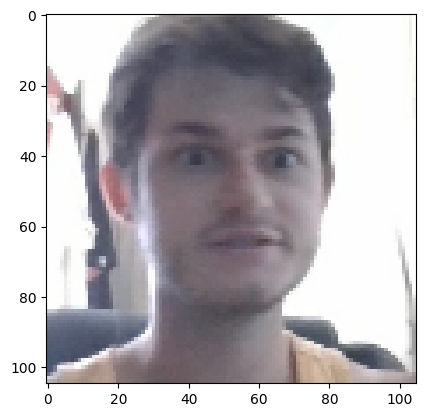

In [14]:
plt.imshow(res[1])

In [15]:
res[2]

1.0

In [16]:
# Dataloader pipeline
data = data.map(twin_preprocess) # ERROR TO_DO
data = data.cache()
data = data.shuffle(buffer_size=1024) # Simply mix the positive and negative images

In [17]:
# Training partition
train_data = data.take((round(len(data)*0.7))) # Get 70% of the samples
train_data = train_data.batch(16) # Pass 16 images each time
train_data = train_data.prefetch(8) # Preprocess the next image beforehand


In [18]:
# Testing Partition
test_data = data.skip((round(len(data)*0.7)))
test_data = test_data.take((round(len(data)*0.3)))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [19]:
# Embedding layer

def make_embedding():
    # Input
    inp = Input(shape=(105, 105, 3), name="input_image")

    # First block
    # Convolusion layer
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    # Max pooling layer
    m1  = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [ ]:
inp = Input(shape=(105, 105, 3), name="input_image")
c1 = Conv2D(64, (10, 10), activation="relu")(inp)
m1  = MaxPooling2D(64, (2, 2), padding="same")(c1)
c2 = Conv2D(128, (7, 7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)
c3 = Conv2D(128, (4, 4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)
c4 = Conv2D(256, (4, 4), activation="relu")(m3)
f1 = Flatten()(c4) # will output 6*6*256
d1 = Dense(4096, activation="sigmoid")(f1)
mod = Model(inputs=[inp], outputs=[d1], name="embedding")


In [20]:
embedding = make_embedding()

In [21]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [22]:
# Distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # We input our anchor embedding and either a posivite or negative embedding and output their distance
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [23]:
# Anchor input image
input_image = Input(name="input_img", shape=(105, 105, 3))
# Positive / Negative input image
validation_image = Input(name="validation_img", shape=(105, 105, 3))

inp_emb = embedding(input_image)
val_emb = embedding(validation_image)

siam = L1Dist()
distances = siam(inp_emb, val_emb)

# Classification layer
classifier = Dense(1, activation="sigmoid")(distances)

s = Model(inputs=[input_image, validation_image], outputs=classifier, name="Siamese_Network")

#s.summary()


In [24]:
siam(inp_emb, val_emb)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [25]:
# Siamese model
def make_siamese_model():
    # Anchor input image
    input_image = Input(name="input_img", shape=(105, 105, 3))
    # Positive / Negative input image
    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    # Combine Siamese distance
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name="Siamese_Network")

In [26]:
siamese_model = make_siamese_model()

In [27]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]    

In [93]:
for layer in siamese_model.layers:
    print(layer)
    print(layer.get_weights())

[]
[]
[array([[[[ 1.33532630e-02, -1.51404394e-02,  1.76973790e-02, ...,
           2.82849539e-02, -7.57566327e-03, -1.00679407e-02],
         [ 1.07432408e-02,  1.56450793e-02,  1.28635811e-02, ...,
           1.97656807e-02, -1.64490715e-02,  1.53193008e-02],
         [-7.22752884e-03,  8.54039332e-04, -2.35258825e-02, ...,
          -1.92856677e-02,  3.37472954e-03, -1.41334822e-02]],

        [[ 6.47764094e-03, -6.88656932e-03,  1.33382366e-03, ...,
          -5.77071449e-03, -1.06870579e-02, -2.73175482e-02],
         [-2.48350296e-02,  2.22099815e-02, -2.44160723e-02, ...,
          -2.49652639e-02, -1.66286696e-02, -1.18720289e-02],
         [ 2.67061889e-02, -2.34750323e-02,  1.95087623e-02, ...,
          -9.78518836e-03, -1.31199881e-02,  6.91981707e-03]],

        [[-1.29763111e-02,  1.19781448e-02, -7.46103050e-03, ...,
           2.51489482e-03,  2.87509635e-02,  1.34439860e-02],
         [ 1.97220836e-02,  1.54601838e-02, -1.48959528e-03, ...,
           1.40504132e-03, 

In [1]:
# Setup loss function
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=True) #from_logits=True

NameError: name 'tf' is not defined

In [94]:
# Compile the model with the contrastive loss
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=binary_cross_loss)

ValueError: Could not interpret optimizer identifier: <keras.optimizers.optimizer_v2.adam.Adam object at 0x0000026F1D453CD0>

In [29]:
# Setup optimizer
opt = tf.keras.optimizers.Adam(1e-4) # 1e - 4 = 0.0001

In [46]:
siamese_model.compile(optimizer="adam", loss=binary_cross_loss)

In [47]:
# Checkpoints
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [48]:
test_batch = train_data.as_numpy_iterator()

In [49]:
batch_1 =test_batch.next()

In [50]:
x = batch_1[:2]
y = batch_1[2]

In [51]:
y

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [52]:
batch_1

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9875706 , 0.99326617, 0.9715108 ],
          [0.95508873, 0.9590103 , 0.9354809 ],
          [0.990943  , 0.9948646 , 0.96349204]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9887622 , 0.9962318 , 0.9709284 ],
          [0.952421  , 0.9563426 , 0.93281317],
          [0.98572093, 0.9896425 , 0.9588302 ]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9929039 , 0.998226  , 0.97507006],
          [0.9457516 , 0.9496732 , 0.92614377],
          [0.9882353 , 0.99215686, 0.96862745]],
 
         ...,
 
         [[0.6917834 , 0.6447246 , 0.65256774],
          [0.65481

In [89]:
# Define the training step for each batch of data based on the following steps:
# 1. Make a prediction
# 2. Calculate loss
# 3. Derive gradients
# 4. Calculate new weights and apply

@tf.function # Compiles the function into callable TensorFlow graph
             # aka it helps train the model efficiently
def train_step(batch):
    with tf.GradientTape() as tape: # Helps us can capture the garients
        # Get anchor  and positive/negative image
        x = batch[:2]  # Each batch cointains 16 anchors, 16 positives/negatives and 16 labels
        # Get label
        y_true = batch[2]

        # Forwar pass
        y_pred = siamese_model(x, training=True) # Make a prediction
                                               # **Training = True is importanyt to activate all the layers
        # Calculate loss
        loss = binary_cross_loss(y_true, y_pred) # Calculate loss (true value, prediction)
    
    # Calculate gradients with respect to the loss
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate update weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    #return loss

In [90]:
# Train loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print("'n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # Optional and simply for the visuals

        # Look through each batch
        for idx, batch in enumerate(data):
            # Run train step
            train_step(batch)
            progbar.update(idx + 1) 

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)




In [55]:
EPOCHS = 1

In [56]:
train(train_data, EPOCHS)

'n Epoch 1/1
27/27 [==============================] - 569s 21s/step


In [69]:
# Evaluate the model
from tensorflow.python.keras.metrics import Precision, Recall
# Note: Precision demonstrates the proporion of correct positive identifications
#       Recall demostrates the proportion of the ACTUAL positive that were correctly identified

# Get a batch of data
test_input, test_value, y_true = test_data.as_numpy_iterator().next()

In [70]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [71]:
# Make predictions
y_pred = siamese_model.predict([test_input, test_value])

In [72]:
y_pred

array([[6.1650644e-03],
       [9.9432808e-01],
       [9.9518365e-01],
       [9.0238243e-01],
       [7.0870605e-08],
       [7.6789010e-01],
       [4.5690484e-07],
       [9.1026241e-01],
       [3.7838920e-06],
       [2.8205584e-04],
       [9.0030974e-01],
       [3.1795322e-03],
       [1.9538090e-04],
       [9.9649304e-01],
       [9.9296498e-01],
       [1.9335122e-05]], dtype=float32)

In [73]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [74]:
[1 if prediction > 0.5 else 0 for prediction in y_pred]

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]

In [75]:
# Post processing the results (aka we create a threshhold so that any numbers above that 
# become => 1 otherwise => 0)
[1 if prediction > 0.5 else 0 for prediction in y_pred]

# Compare the above list to the labels to see if the outputs match the real results
m = Recall()

# Calculate the recall value
m.update_state(y_true,y_pred)

# Return the recall result (pretty much how accurate the model is)
# 1 = perfect  |   0 = horibble
m.result().numpy()

1.0

In [ ]:
# Visualise the results
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_value[0])
plt.show()

In [86]:
# Save Model

# Save weights
siamese_model.save("siamesemodel1.h5")

In [87]:
L1Dist

__main__.L1Dist

In [88]:
# Reload Model
model = tf.saved_model.load('siamesemodel1.h5')
#model = tf.keras.models.load_model('siamesemodelv2.h5', 
#                                   custom_objects={'L1Dist':L1Dist})

OSError: SavedModel file does not exist at: siamesemodel1.h5\{saved_model.pbtxt|saved_model.pb}

In [82]:
model.load_weights("siamesemodelv2.h5")

NameError: name 'model' is not defined

In [83]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
model.predict([test_input, test_value])

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))

        # Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
    
    # Detection Threshold: A metric above which a prediction is considered postve
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions total positive samples
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold
    
    


In [4]:
# OpenCV Real Time Verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:370, 200:450, :]

    cv2.imshow("Verification", frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)

        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()